# Multiple time series prediction for random laser spectrra based on CNN-LSTM-Attention model

In [1]:
"""
@author: shilong he
"""

import graphviz
import keras.backend
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import *
from keras.losses import mean_squared_error
from keras.models import *
from keras.utils import plot_model
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# import pydot_ng as pydot
from tensorflow.keras.utils import plot_model
np.random.seed(10)

Using TensorFlow backend.


In [2]:
import platform
print('python_version',platform.python_version())

print('tensorflow_version',tf.__version__)
for module in keras, graphviz, np, pd:
    print(module.__name__, module.__version__)

python_version 3.6.13
tensorflow_version 2.0.0
keras 2.3.1
graphviz 0.19.1
numpy 1.19.5
pandas 1.1.5


## Import spectra

In [3]:
#  Import total spectral data
sum_data = np.load("12.13-2_5000.npy")

# [start, end] = plt.ginput(2)
# x1, y1 = start[0], start[1]
# x2, y2 = end[0], end[1]

x1 = 562
x2 = 585

Mat_crop_length：134


Text(0.5, 1.0, 'Crop Spectrum')

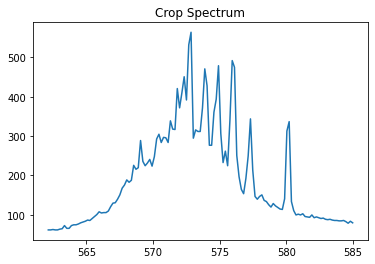

In [4]:
# Crop
index = (sum_data[0, :, 0] > x1) & (sum_data[0, :, 0] < x2)
Mat_crop = sum_data[:, index, :]

numChannels = Mat_crop.shape[1]
print("Mat_crop_length：{}".format(numChannels))  # 196

plt.figure()
plt.plot(Mat_crop[0, :, 0], Mat_crop[0, :, 1])
plt.title("Crop Spectrum")

In [5]:
# transposed
DataY = np.squeeze(Mat_crop[:, :, 1])
frame = DataY.shape[0]
frame, DataY.shape

(5000, (5000, 134))

## Spectral standardization

In [6]:
X = DataY  # import data
scaler = StandardScaler()
train_x, test_x = train_test_split(
    X, train_size=int(0.8 * frame), test_size=int(0.2 * frame - 1), shuffle=False
)
train_x.shape

(4000, 134)

In [7]:
scaler = StandardScaler()
train_x_row_std = scaler.fit_transform(train_x.T).T
test_x_row_std = scaler.fit_transform(test_x.T).T

train_x = train_x_row_std
test_x = test_x_row_std
train_x.shape

(4000, 134)

In [8]:
train_frame = train_x.shape[0]
test_frame = test_x.shape[0]
train_frame, test_frame

(4000, 999)

Text(0.5, 1.0, 'Standardization Spectrum')

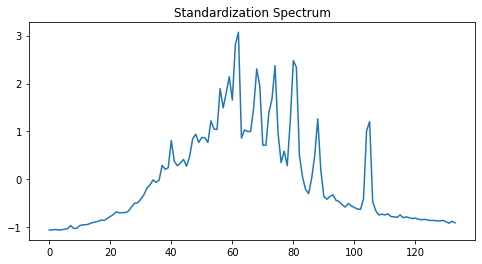

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(train_x[0,:])  # 第一行
plt.title("Standardization Spectrum")

## Reconstructing 3D arrays with time steps

In [10]:
# batch
time_step = 5   #16 32
dataX, dataY = [], []
for i in range(train_frame - time_step):
    a = train_x[i : time_step + i, :]
    dataX.append(a)
    dataY.append(train_x[i+1 : time_step + i+1, :])
train_X = np.array(dataX)
train_Y = np.array(dataY)  # .reshape(-1,numChannels,1)
print(train_X.shape)
print(train_Y.shape)

(3995, 5, 134)
(3995, 5, 134)


In [11]:
testX, testY = [], []
for i in range(test_frame - time_step):
    a = test_x[i : time_step + i, :]
    testX.append(a)
    testY.append(test_x[i+1 : time_step + i+1, :])
test_X = np.array(testX)
test_Y = np.array(testY)  # .reshape(-1,numChannels,1)
print(test_X.shape)
print(test_Y.shape)

(994, 5, 134)
(994, 5, 134)


## CNN+LSTM+Attention model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 134)       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 5, 256)       34560       input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 5, 256)       0           dense_1[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 256, 5)       0           dropout_1[0][0]                  
____________________________________________________________________________________________

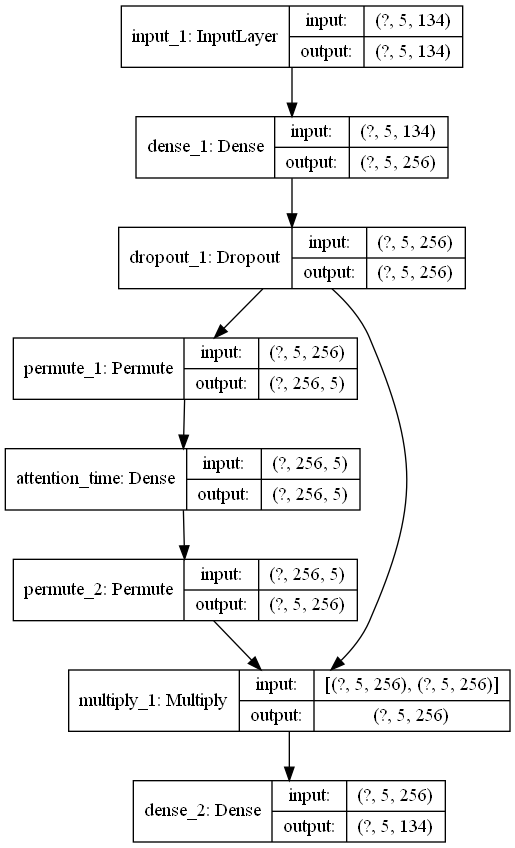

In [12]:
dropout = 0.2

inputs = Input(shape=(time_step,numChannels))

model = Dense(256)(inputs)
model = Dropout(dropout)(model)

attention_time = Permute(dims=(2, 1))(model)
# Attention
attention_time = Dense(time_step, activation="softmax", name="attention_time")(attention_time)  # Attention
attention_time = Permute(dims=(2, 1))(attention_time)
lambda0 = Multiply()([model, attention_time]) 

# lambda_sum = Lambda(lambda x:keras.backend.sum(x,axis=1,keepdims=False))(lambda0) 


predictions = Dense(numChannels)(lambda0)

model = Model(inputs=inputs, outputs=predictions)

# compile
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

model.summary()  # Demonstrate model structure

plot_model(model, show_shapes=True, show_layer_names=True)  # Display Structure Forms,to_file='model.png'

In [13]:
# Train
history = model.fit(
    train_X,
    train_Y,
    epochs=100,
    batch_size=64, # 16 32 64
    validation_data=(test_X, test_Y),
    verbose=2,
    shuffle=True,
)

Train on 3995 samples, validate on 994 samples
Epoch 1/100
 - 0s - loss: 0.2925 - accuracy: 0.1682 - val_loss: 0.1032 - val_accuracy: 0.2179
Epoch 2/100
 - 0s - loss: 0.1131 - accuracy: 0.2262 - val_loss: 0.0961 - val_accuracy: 0.2237
Epoch 3/100
 - 0s - loss: 0.1043 - accuracy: 0.2321 - val_loss: 0.0944 - val_accuracy: 0.2266
Epoch 4/100
 - 0s - loss: 0.1000 - accuracy: 0.2376 - val_loss: 0.0924 - val_accuracy: 0.2245
Epoch 5/100
 - 0s - loss: 0.0975 - accuracy: 0.2396 - val_loss: 0.0913 - val_accuracy: 0.2256
Epoch 6/100
 - 0s - loss: 0.0959 - accuracy: 0.2401 - val_loss: 0.0916 - val_accuracy: 0.2237
Epoch 7/100
 - 0s - loss: 0.0948 - accuracy: 0.2441 - val_loss: 0.0913 - val_accuracy: 0.2239
Epoch 8/100
 - 0s - loss: 0.0938 - accuracy: 0.2440 - val_loss: 0.0903 - val_accuracy: 0.2254
Epoch 9/100
 - 0s - loss: 0.0931 - accuracy: 0.2441 - val_loss: 0.0899 - val_accuracy: 0.2254
Epoch 10/100
 - 0s - loss: 0.0927 - accuracy: 0.2456 - val_loss: 0.0899 - val_accuracy: 0.2249
Epoch 11/100

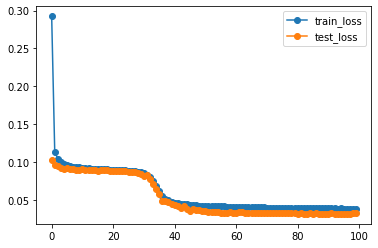

In [14]:
# Loss
plt.plot(history.history["loss"],'o-', label="train_loss")
plt.plot(history.history["val_loss"],'o-', label="test_loss")
# plt.ylim(0, 0.2)
plt.legend()
plt.show()

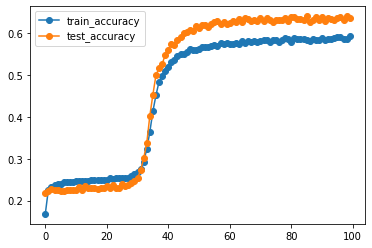

In [15]:
plt.plot(history.history["accuracy"],'o-', label="train_accuracy")
plt.plot(history.history["val_accuracy"],'o-', label="test_accuracy")
# plt.ylim(0, 0.5)
plt.legend()
plt.show()

## Forecasting

In [16]:
test_Y_predict = model.predict(test_X)
test_Y_predict.shape, test_Y.shape

((994, 5, 134), (994, 5, 134))

In [28]:
# np.save('test_Y_RL_DNN',test_Y)
# np.save('test_Y_predict_RL_DNN',test_Y_predict)

test_Y= np.load("test_Y_RL_DNN.npy")
test_Y_predict = np.load('test_Y_predict_RL_DNN.npy')

# from scipy import io
# mat=np.load('test_Y_article.npy')
# io.savemat('test_Y_134_32.mat', {'test_Y_134_32': mat})
# mat1=np.load('test_Y_article_predict.npy')
# io.savemat('test_Y_134_32_predict.mat', {'test_Y_134_32_predict': mat1})

Text(0.5, 1.0, 'Test Data 2')

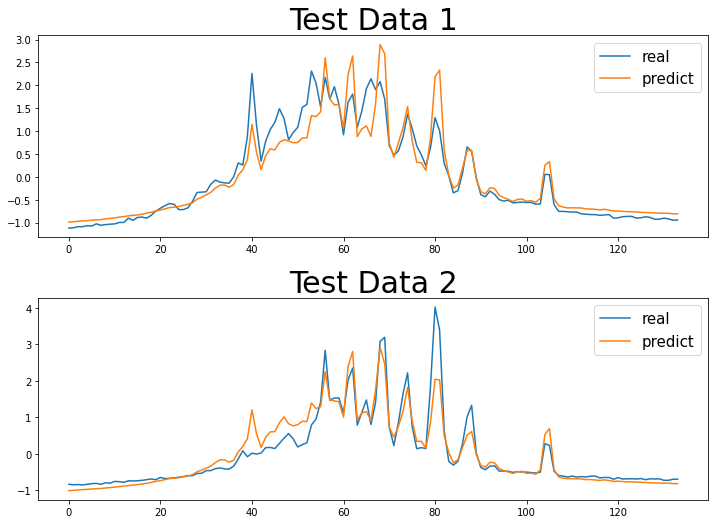

In [18]:
fig = plt.figure(figsize=(16,16))  # 宽，高
fig.subplots_adjust(hspace=0.3, wspace=0.1,top=1.2)  # 间距
plt.subplot(211)
draw = pd.concat([pd.DataFrame(test_Y[0,-1, :]), pd.DataFrame(test_Y_predict[0,-1, :])], axis=1)
draw.iloc[:, 0].plot(figsize=(12, 6))
draw.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 1", fontsize="30")  # 添加标题

plt.subplot(212)
draw2 = pd.concat([pd.DataFrame(test_Y[1,-1, :]), pd.DataFrame(test_Y_predict[1,-1, :])], axis=1)
draw2.iloc[:, 0].plot(figsize=(12, 6))
draw2.iloc[:, 1].plot(figsize=(12, 6))
plt.legend(("real", "predict"), fontsize="15")
plt.title("Test Data 2", fontsize="30")  # 添加标题

Text(0.5, 0, 'Timestamp')

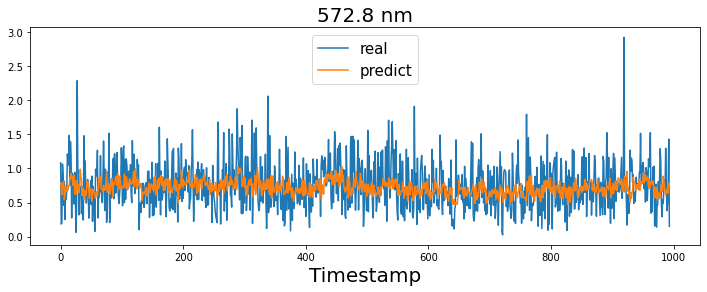

In [20]:
m=50
draw2 = pd.concat([pd.DataFrame(test_Y[:,-1,m]), pd.DataFrame(test_Y_predict[:,-1,m])], axis=1)
draw2.iloc[:, 0].plot(figsize=(12, 4))
draw2.iloc[:, 1].plot(figsize=(12, 4))

plt.legend(("real", "predict"), fontsize="15")
plt.title("572.8 nm", fontsize="20")  
plt.xlabel("Timestamp", fontsize="20")

Text(0.5, 0, 'Timestamp')

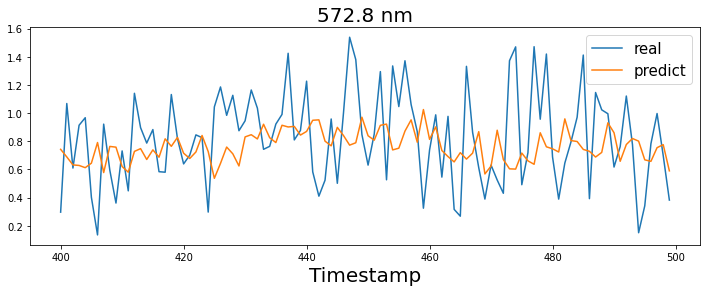

In [22]:
draw2_crop = pd.concat([pd.DataFrame(test_Y[400:500,-1,m]), pd.DataFrame(test_Y_predict[400:500,-1,m])], axis=1)
draw2_crop.iloc[:, 0].plot(figsize=(12, 4))
draw2_crop.iloc[:, 1].plot(figsize=(12, 4))
plt.xticks([0,20,40,60,80,100],[400,420,440,460,480,500])
plt.legend(("real", "predict"), fontsize="15")
plt.title("572.8 nm", fontsize="20")  
plt.xlabel("Timestamp", fontsize="20")

In [23]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


print("Test set:")
print("MAE:{}".format(mean_absolute_error(test_Y_predict, test_Y)))
print("MSE:{}".format(mean_squared_error(test_Y_predict, test_Y)))
print("MAPE:{}".format(mape(test_Y_predict, test_Y)))

Test set:


ValueError: Found array with dim 3. Estimator expected <= 2.

In [25]:
from scipy.stats import pearsonr
correlation, _ = pearsonr(test_Y[:,-1,m], test_Y_predict[:,-1,m])
correlation

0.05210977098992232

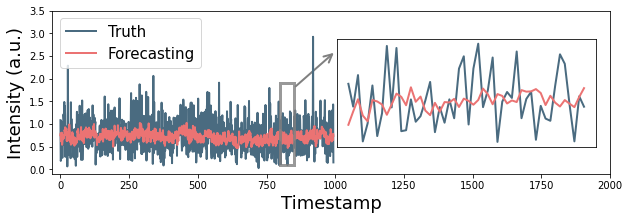

In [27]:
from matplotlib.patches import Rectangle, FancyArrowPatch

# 创建一个大的图形和坐标轴
fig, ax1 = plt.subplots(figsize=(10,3))
m=50
# 在大坐标轴上绘制数据
ax1.plot(test_Y[:,-1,m], color=[0.29,0.42,0.50],linewidth=2)
ax1.plot(test_Y_predict[:,-1,m], color=[0.92,0.45,0.45],linewidth=2)
plt.legend(("Truth", "Forecasting"), fontsize="15", loc="upper left")
plt.xlabel("Timestamp", fontsize="18")
plt.ylabel("Intensity (a.u.)", fontsize="18")
plt.ylim(-0.1,3.5)
plt.xlim(-30,2000)

# 创建一个小的坐标轴，位置和大小由坐标轴的坐标（左、下、宽、高）决定
# 这些坐标值的范围在0到1之间，表示相对于大坐标轴的位置和大小
ax2 = fig.add_axes([0.52, 0.25, 0.36, 0.5])  # [left, bottom, width, height]

# 在小坐标轴上绘制数据
ax2.plot(test_Y[800+27:850+27,-1,m], color=[0.29,0.42,0.50],linewidth=2)
ax2.plot(test_Y_predict[800+27:850+27,-1,m], color=[0.92,0.45,0.45],linewidth=2)
plt.xticks([])
plt.yticks([])
# ax2.set_title('小图')

# 添加矩形框
# 矩形框的位置和大小由坐标轴的坐标（左、下、宽、高）决定
rect = Rectangle((800, 0.1), 50, 1.8, linewidth=3, edgecolor='gray', facecolor='none', alpha=0.8, linestyle='-', zorder=10)
ax1.add_patch(rect)

# 添加箭头
# 箭头的起点和终点坐标需要根据实际位置进行调整
arrow = FancyArrowPatch((850, 1.8), (1000, 2.6), arrowstyle='->', mutation_scale=20, color='gray', linewidth=2)
ax1.add_patch(arrow)

# plt.savefig("DNN_RL_all.pdf",dpi=300, bbox_inches='tight')

# 显示图形
plt.show()